In [1]:
import sys
import os

# project_root = os.path.abspath('..') 
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)
%cd ..

import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import seg_model.inference as seg_infer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/talmacsi/Documents/BME/WeatherConverter


In [2]:
def apply_gsg(
    seg_model: nn.Module, mu: torch.Tensor, sigma: torch.Tensor, sr_xt: torch.Tensor, gt: torch.Tensor, _lambda: float
) -> torch.Tensor:
    # Adjust mu based on global guidance
    # L(global)[xt, y] = L(ce)[g(xt), y]
    # mu_hat(xt, t) = mu(xt, t) + lambda * sigma * gradient(L(global)[xt,y])

    _, input_gradients, _ = seg_infer.infer(seg_model, sr_xt, gt)

    gradients_avg_128 = F.avg_pool2d(input_gradients, kernel_size=4, stride=4)
    gradient_magnitude_avg_128 = seg_infer.compute_gradient_magnitude(gradients_avg_128, denormalize=True, norm=False)

    mu_hat = mu + _lambda * sigma * gradient_magnitude_avg_128
    xt = mu_hat + sigma

    return xt


def apply_lcg(
    seg_model: nn.Module, mu: torch.Tensor, sigma: torch.Tensor, sr_xt: torch.Tensor, gt: torch.Tensor, _lambda: float
) -> torch.Tensor:
    # L(local)[xt, y, c] = L(ce)([g(xt * mc)], y*mc)
    # mu_hat(xt, t, c) = mu(xt, t) + lambda * sigma * gradient(L(local)[xt, y, c])
    # xt_c = mu_hat + sigma
    # xt = sum_c(mc * xt_c)

    # Adjust mu based on local guidance
    xt_c_list = []
    mc_list = []

    for c in range(19):  # 19 classes
        # Generate class-specific mask
        mc = (gt == c).long().unsqueeze(1).to(device)  # [1,1,512,512]
        mc_list.append(mc)

        xt_masked = sr_xt * mc  # [1,3,512,512]
        gt_masked = gt * mc.squeeze(0)  # [1,512,512]

        _, input_gradients, _ = seg_infer.infer(seg_model, xt_masked, gt_masked)

        gradients_avg_128 = F.avg_pool2d(input_gradients, kernel_size=4, stride=4)
        gradient_magnitude_avg_128 = seg_infer.compute_gradient_magnitude(gradients_avg_128, denormalize=True, norm=False)

        mu_hat_c = mu + _lambda * sigma * gradient_magnitude_avg_128
        xt_c = mu_hat_c + sigma

        xt_c_list.append(xt_c)

    # Sum all class-specific xt_c
    xt = torch.sum(torch.stack(xt_c_list) * torch.stack(mc_list), dim=0)

    return xt

## Load test data and model

In [3]:
# ---------- Load Segment Model ----------
seg_config = seg_infer.load_config('seg_model/config/config.yaml')
seg_model_path = os.path.join(seg_config.folders.checkpoints, 'deeplabv3plus_resnet101_epoch_28.pth')
seg_model = seg_infer.load_model(seg_model_path, seg_config.model)

# ---------- Load Test Data ----------
rgb_anon_path = Path(seg_config.data.root_dir) / seg_config.data.images
gt_path = Path(seg_config.data.root_dir) / seg_config.data.labels
gt_label_ids_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelIds.png')  # (0-32 values)
gt_color_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelColor.png')  # (RGB values)
input_image_path = str(rgb_anon_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_rgb_anon.png')
input_image = Image.open(input_image_path).convert("RGB")

# ---------- Preprocess Test Data ----------
_, input_tensor_512, encoded_label_tensor_512, lbl_colored_img_512 = seg_infer.preprocess(ori_img_path=input_image_path, img_path=input_image_path, gt_label_ids_path=gt_label_ids_path, gt_color_path=gt_color_path)

In [19]:
sr_xt = input_tensor_512.to(device)
gt = encoded_label_tensor_512.to(device)
mu_sigma = torch.load('debug/mu_sigma_499.pt')
mu = mu_sigma['mu']
sigma = mu_sigma['sigma']
_lambda = 60.0


In [12]:
print(sr_xt.shape, gt.shape, mu.shape, sigma.shape)
print(sr_xt.device, gt.device, mu.device, sigma.device)

torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512]) torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
cuda:0 cuda:0 cuda:0 cuda:0


## Test GSG

In [17]:
import matplotlib.pyplot as plt

def plot_tensor(tensor: torch.Tensor):
# Convert input tensor to numpy array for visualization
    image_np = tensor.squeeze(0).detach().cpu().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))  # From [C, H, W] to [H, W, C]
    image_np = np.clip(image_np, 0, 1) * 255
    image_np = image_np.astype(np.uint8)

    plt.imshow(image_np)
    plt.show()

In [20]:
preds, input_gradients, _ = seg_infer.infer(seg_model, sr_xt, gt)

gradients_avg_128 = F.avg_pool2d(input_gradients, kernel_size=4, stride=4)
gradient_magnitude_avg_128 = seg_infer.compute_gradient_magnitude(gradients_avg_128, denormalize=False, norm=False)
gradient_magnitude_avg_128 = gradient_magnitude_avg_128.to(device)

mu_hat = mu + _lambda * sigma * gradient_magnitude_avg_128
xt = mu_hat + sigma

Input Tensor requires gradient: True
Input tensor gradient: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')
Output tensor shape: torch.Size([1, 19, 512, 512])
Predicted tensor shape: (512, 512)
Gradient min: 1.3714712e-06
G

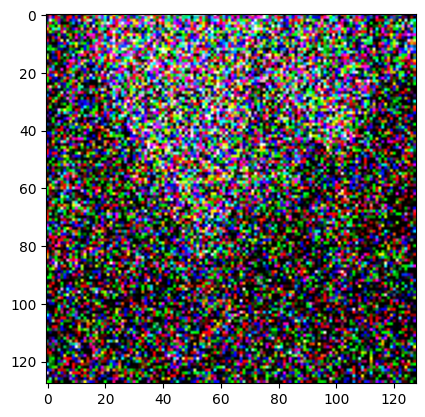

In [21]:
plot_tensor(xt)